In [14]:
import cv2 
import os 
import glob
import json
import csv
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

from functools import partial
from p_tqdm import p_map
from tqdm import tqdm 
from module.utils import imread, imfindcircles, findProjectiveTransform, str2array, circle_detection_multi_thread
from module.disp_measure import displacement_measure, homography_transformation

# Import circle detection and APCA parameters 
with open('params.json') as param_config_json : 
    param_config = json.load(param_config_json)



In [15]:
'''
1. Check if any images where circles detection is not performed.
& Run imfindcircles for recently added images and save to csv 
'''
# if analysis_tabel is not empty 
clear_previous_detection_results = False

if clear_previous_detection_results : 
    analysis_table = pd.DataFrame(columns=['image_name','centers_of_detected_circles','sensitivity',
                                           'num_centers','x_displacement','y_displacement'])
else : 
    analysis_table = pd.read_csv('analysis_table.csv')
sensor_info = pd.read_csv('sensor_info.csv')
dataset_folder = '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/'

analysis_period = [20200901, 90200901] # [starting time, end time]

sensor_info = sensor_info[(sensor_info['APCA_Group'] == 1)] # desired apca target group

In [16]:
img_sensor_list = sensor_info[(sensor_info['Sensor Type'] == 'Img')]['Sensor ID']
img_list_for_cd = []

for sensor_id in img_sensor_list:
    # check installation year 
    
    install_year = sensor_info[(sensor_info['Sensor ID'] == sensor_id)]['Sensor Installation Year'].values[0]
    img_foler_name = os.path.join(dataset_folder, str(install_year), 'data')
    sensor_img_list = glob.glob(os.path.join(img_foler_name, 'Img_' + str(sensor_id).zfill(3)+'*.jpg'))
    
    for sensor_img in sensor_img_list: 
        sensor_img_date = int(os.path.basename(sensor_img)[8:16])
        if (sensor_img_date >= analysis_period[0]) and (sensor_img_date <= analysis_period[1]):
            img_list_for_cd.append(sensor_img)

    
img_list_for_cd.sort()
    

In [18]:
re_circle_detection_list = []
run_circle_detection_list = []

# create a list of imgs to which re-run circle detection 
for img_file in img_list_for_cd : 
    img_name = os.path.basename(img_file)
    num_image_in_the_cvs = len(np.where(analysis_table['image_name']== img_name)[0])
    if num_image_in_the_cvs : 
        img_idx = int(np.where(analysis_table['image_name']== img_name)[0]) 
        num_circles = analysis_table['num_centers'][img_idx] 
        if num_circles != 4 :  
            re_circle_detection_list.append(img_file) 
            
    else : 
        run_circle_detection_list.append(img_file)

# re-run circle detection with multi-threading 
if re_circle_detection_list : 
    re_circles_list = p_map(partial(circle_detection_multi_thread, param_config=param_config), re_circle_detection_list)
    
if run_circle_detection_list : 
    run_circles_list = p_map(partial(circle_detection_multi_thread, param_config=param_config), run_circle_detection_list)
    

    # create a list of imgs that circle detection never been done
    # run circle detection using multi-threading 
    # and append the list to analysis table 
    
# sort analysis table by img name 
# save analysis table as csv file 

In [19]:
for img_name, circles in zip(run_circle_detection_list, run_circles_list):
    img_basename = os.path.basename(img_name)
    sensor_num = str(img_basename[4:7])
    params = param_config[sensor_num]
    sensitivity = params['sensitivity']
    new_row = [img_basename , circles, sensitivity,  len(circles), float('NaN'),  float('NaN'),]
    s = pd.Series(new_row, index=analysis_table.columns )
    analysis_table = analysis_table.append(s, ignore_index=True)
    
analysis_table.to_csv('analysis_table.csv', index=False)

In [20]:
'''
2. Convert circle center coord to displacement 
'''
## This code assumes that displace measurement has been done yet. 
## Need to edit this code to work when previous displacement measurement results exist.
analysis_table = pd.read_csv('analysis_table.csv')

x_displacement_list = []
y_displacement_list = []

# since displacement measurement doesn't take so long, 
# This code will be written just to re-write displacement column everytime 

for num, img_name in enumerate(analysis_table['image_name']) :
    try :
        sric_idx = int(np.where(analysis_table['image_name']== param_config[img_name[4:7]]['src_img'])[0]) 
        src_circles = str2array(analysis_table['centers_of_detected_circles'][sric_idx])
        dest_circles = str2array(analysis_table['centers_of_detected_circles'][num])

        displacement = homography_transformation(src_circles, dest_circles)
        x_displacement_list.append(displacement[0][0])
        y_displacement_list.append(displacement[1][0])
        
    except IndexError as error:
    # Output expected IndexErrors.
        print(img_name, error)
        x_displacement_list.append([0])
        y_displacement_list.append([0])
    except Exception as exception:
        # Output unexpected Exceptions.
        print(img_name, exception)
        x_displacement_list.append([0])
        y_displacement_list.append([0])
    
columns_to_overwrite = ['x_displacement', 'y_displacement']
analysis_table.drop(labels=columns_to_overwrite, axis="columns", inplace=True)


analysis_table['x_displacement'] = x_displacement_list
analysis_table['y_displacement'] = y_displacement_list

analysis_table.to_csv('analysis_table.csv',index=False)



In [147]:
# to do 

tmp_sensor_list = sensor_info[(sensor_info['Sensor Type'] == 'Tmp')]['Sensor ID']

tmp_list_for_cd = []

for sensor_id in tmp_list_for_cd:
    # check installation year 
    install_year = sensor_info[(sensor_info['Sensor ID'] == sensor_id)]['Sensor Installation Year'].values[0]
    img_foler_name = os.path.join(dataset_folder, str(install_year), 'data')
    sensor_tmp_list = glob.glob(os.path.join(img_foler_name, 'Tmp_' + str(sensor_id).zfill(3)+'*.jpg'))
    
    for sensor_img in sensor_tmp_list: 
        sensor_img_date = int(os.path.basename(sensor_img)[8:16])
        if (sensor_img_date >= analysis_period[0]) and (sensor_img_date <= analysis_period[1]):
            tmp_list_for_cd.append(sensor_img)

    
tmp_list_for_cd.sort()

# 2. get temperature data in op['t']
    # read temperature data according to the excel file 
    
# 3. get displacement data in op['f']
    # adjust displacement direction using sensor excel file 
# 4. run apca 
# 5. Plot the result 


,Sensor ID,Sensor Type,Pier,Slab No,APCA_Group,Sensor Direction,Sensor Location,Displacement Direction
83,52,sound,P34,34-S,34,E,S,Forward
84,55,sound,P34,34-S,34,E,S,Forward
85,58,sound,P34,34-S,34,E,S,Forward
88,59,sound,P34,34-S,34,E,S,Forward
89,54,Tmp,P34,34-S,34,E,S,Forward
90,57,Tmp,P34,34-S,34,E,S,Forward
91,60,Tmp,P34,34-S,34,E,S,Forward
92,179,Img,P34,34-S,34,S,S,FALSE
93,180,Img,P34,34-S,34,E,S,Forward
94,181,Tmp,P34,34-S,34,E,S,Forward


In [28]:
'''
3. Check if newly added tmp data and 
Import tmp data and save to csv
'''
# Not sure but, It seems that there are missing temp data. 
analysis_table = pd.read_csv('analysis_table.csv')

tmp_list = []
tmp_file_folder = '/media/sss/Seagate Backup Plus Drive/data/' 


for num, img_name in enumerate(analysis_table['image_name']) :
#     tmp_file_name = glob.glob(os.path.join(tmp_file_folder, '*' + img_name[4:24] + '*.tpr'))
#     tmp_file_name = [s for s in tmp_file_list if img_name[4:24] in s]
#     print('Tmp_' + img_name[4:19] + '0000.tpr' )
    try : 
        f = open(os.path.join(tmp_file_folder, 'Tmp_' + img_name[4:19] + '0000.tpr' ), "r")
        print(f.read())
        
    except : 
        print(25)
        print(os.path.join(tmp_file_folder, 'Tmp_' + img_name[4:19] + '0000.tpr' ))

        
# analysis_table = pd.concat([center_list, pd.DataFrame(x_displacement_list), pd.DataFrame(y_displacement_list)], axis=1)
# analysis_table.to_csv('analysis_table.csv',index=False)

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_01_center.j0000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200806_180000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200806_190000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200828_180000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200828_190000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200828_200000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200828_210000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200828_220000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200828_230000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200829_000000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200829_010000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200829_020000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_093_20200829_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_09

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200829_210000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200829_220000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200829_230000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_000000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_010000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_020000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_040000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_050000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_103_20200830_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_10

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_110000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_120000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_130000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_140000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_150000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_160000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_170000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_180000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_190000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_111_20200901_200000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_11

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_110000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_120000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_130000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_140000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_150000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_160000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_170000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200904_180000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200907_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200907_110000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_123_20200907_120000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_12

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200831_220000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200831_230000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_000000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_010000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_020000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_040000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_050000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_135_20200901_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_13

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_110000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_120000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_130000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_140000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_150000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_160000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_170000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_147_20200901_180000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_14

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200828_190000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200828_200000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200828_210000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200828_220000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200828_230000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200829_000000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200829_010000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200829_020000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200829_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200829_040000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200829_050000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200829_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_156_20200829_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_15

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200907_220000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200907_230000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_000000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_010000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_020000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_040000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_050000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_164_20200908_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_16

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_040000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_050000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_110000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_120000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_130000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_140000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_175_20200829_150000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_17

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200902_220000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200902_230000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_000000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_010000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_020000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_040000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_050000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_187_20200903_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_18

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200829_230000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_000000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_010000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_020000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_040000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_050000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_196_20200830_110000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_19

25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200902_230000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_000000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_010000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_020000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_030000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_040000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_050000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_060000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_070000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_080000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_090000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_100000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_204_20200903_110000.tpr
25
/media/sss/Seagate Backup Plus Drive/data/Tmp_20

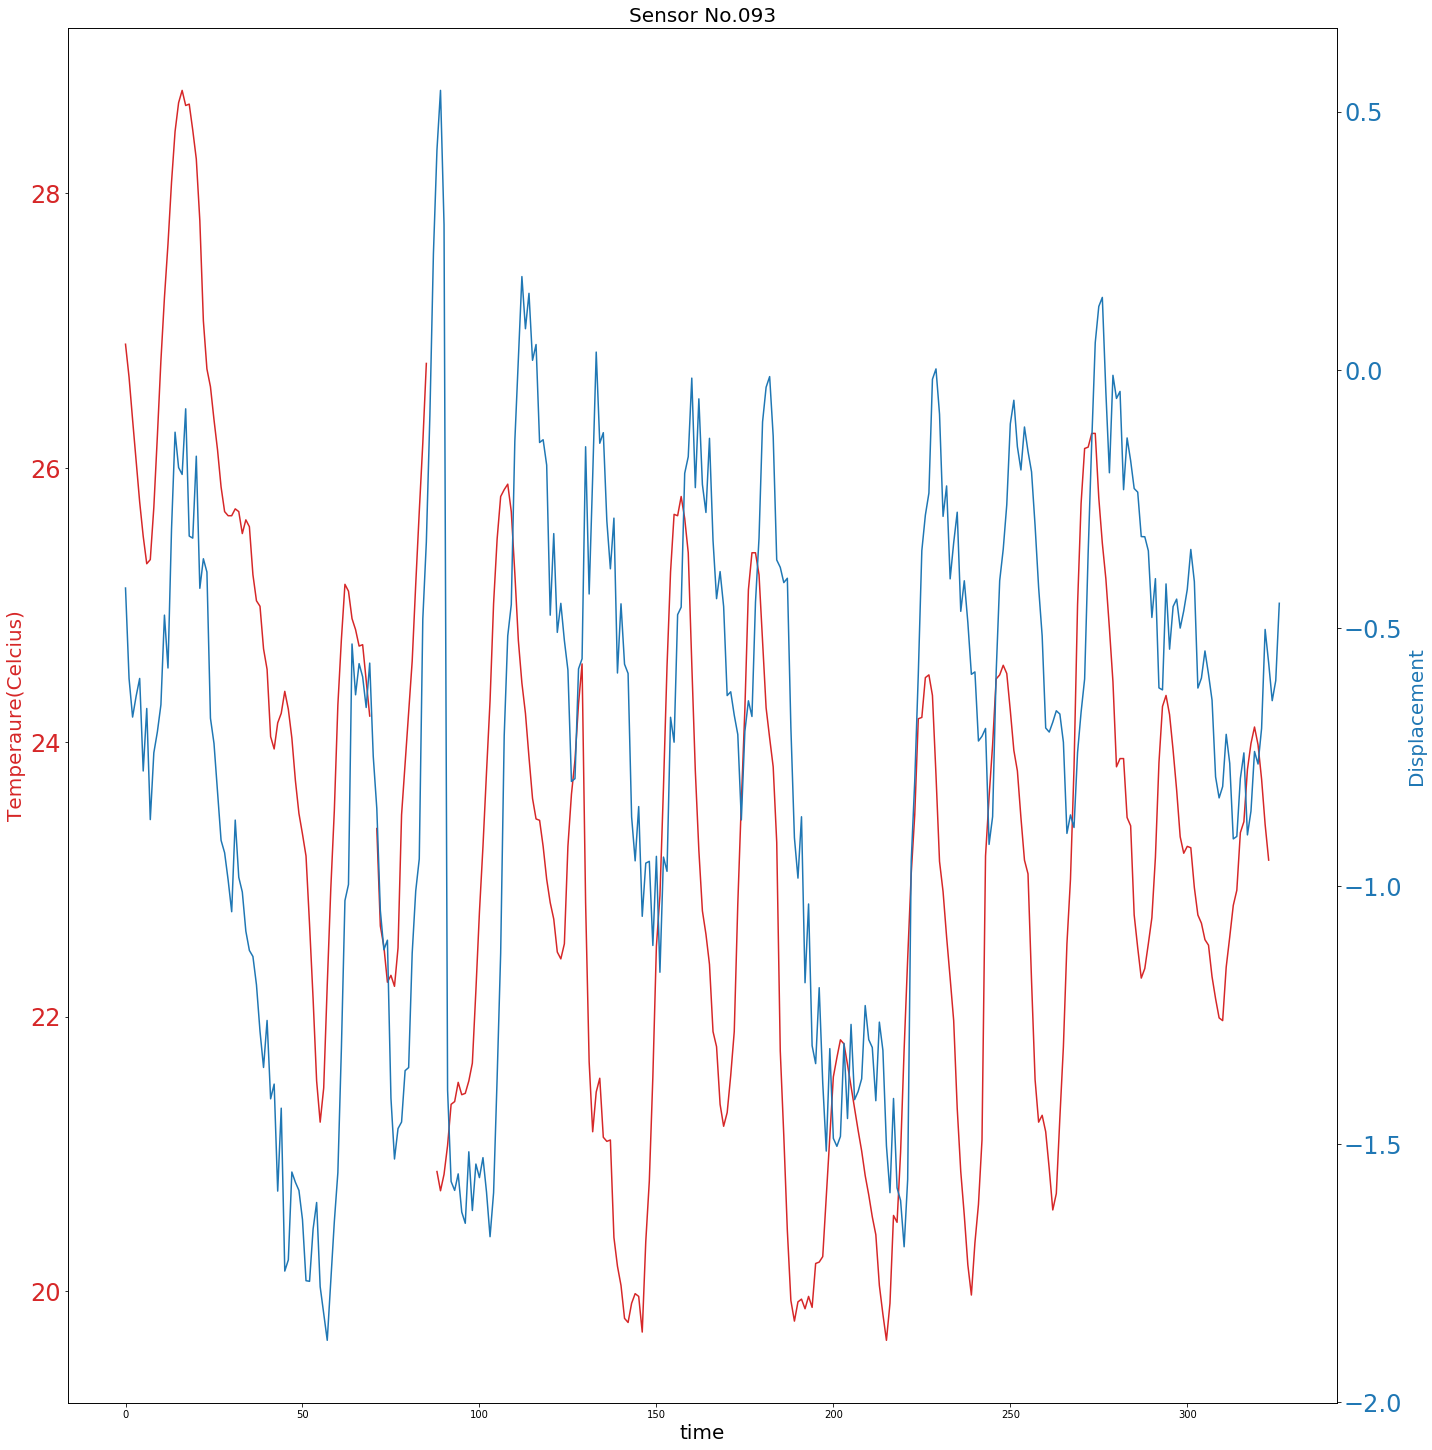

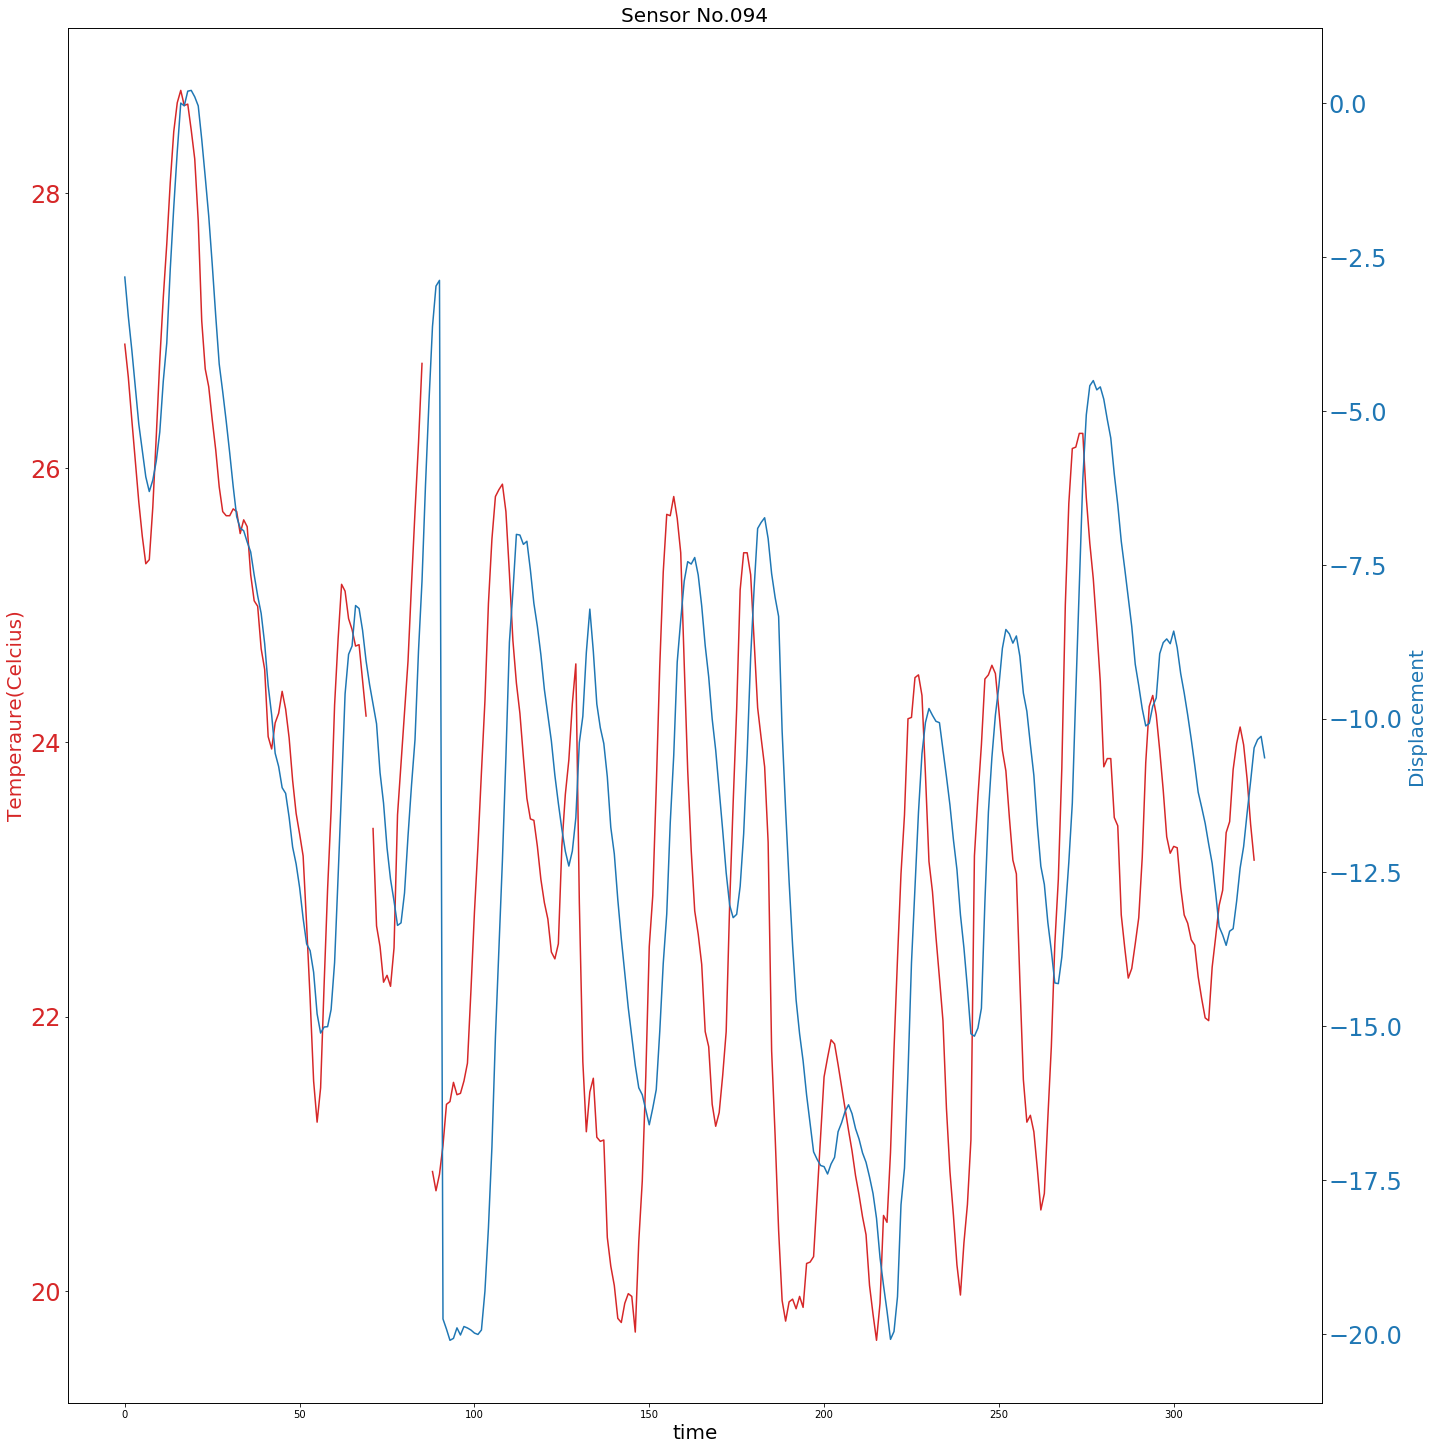

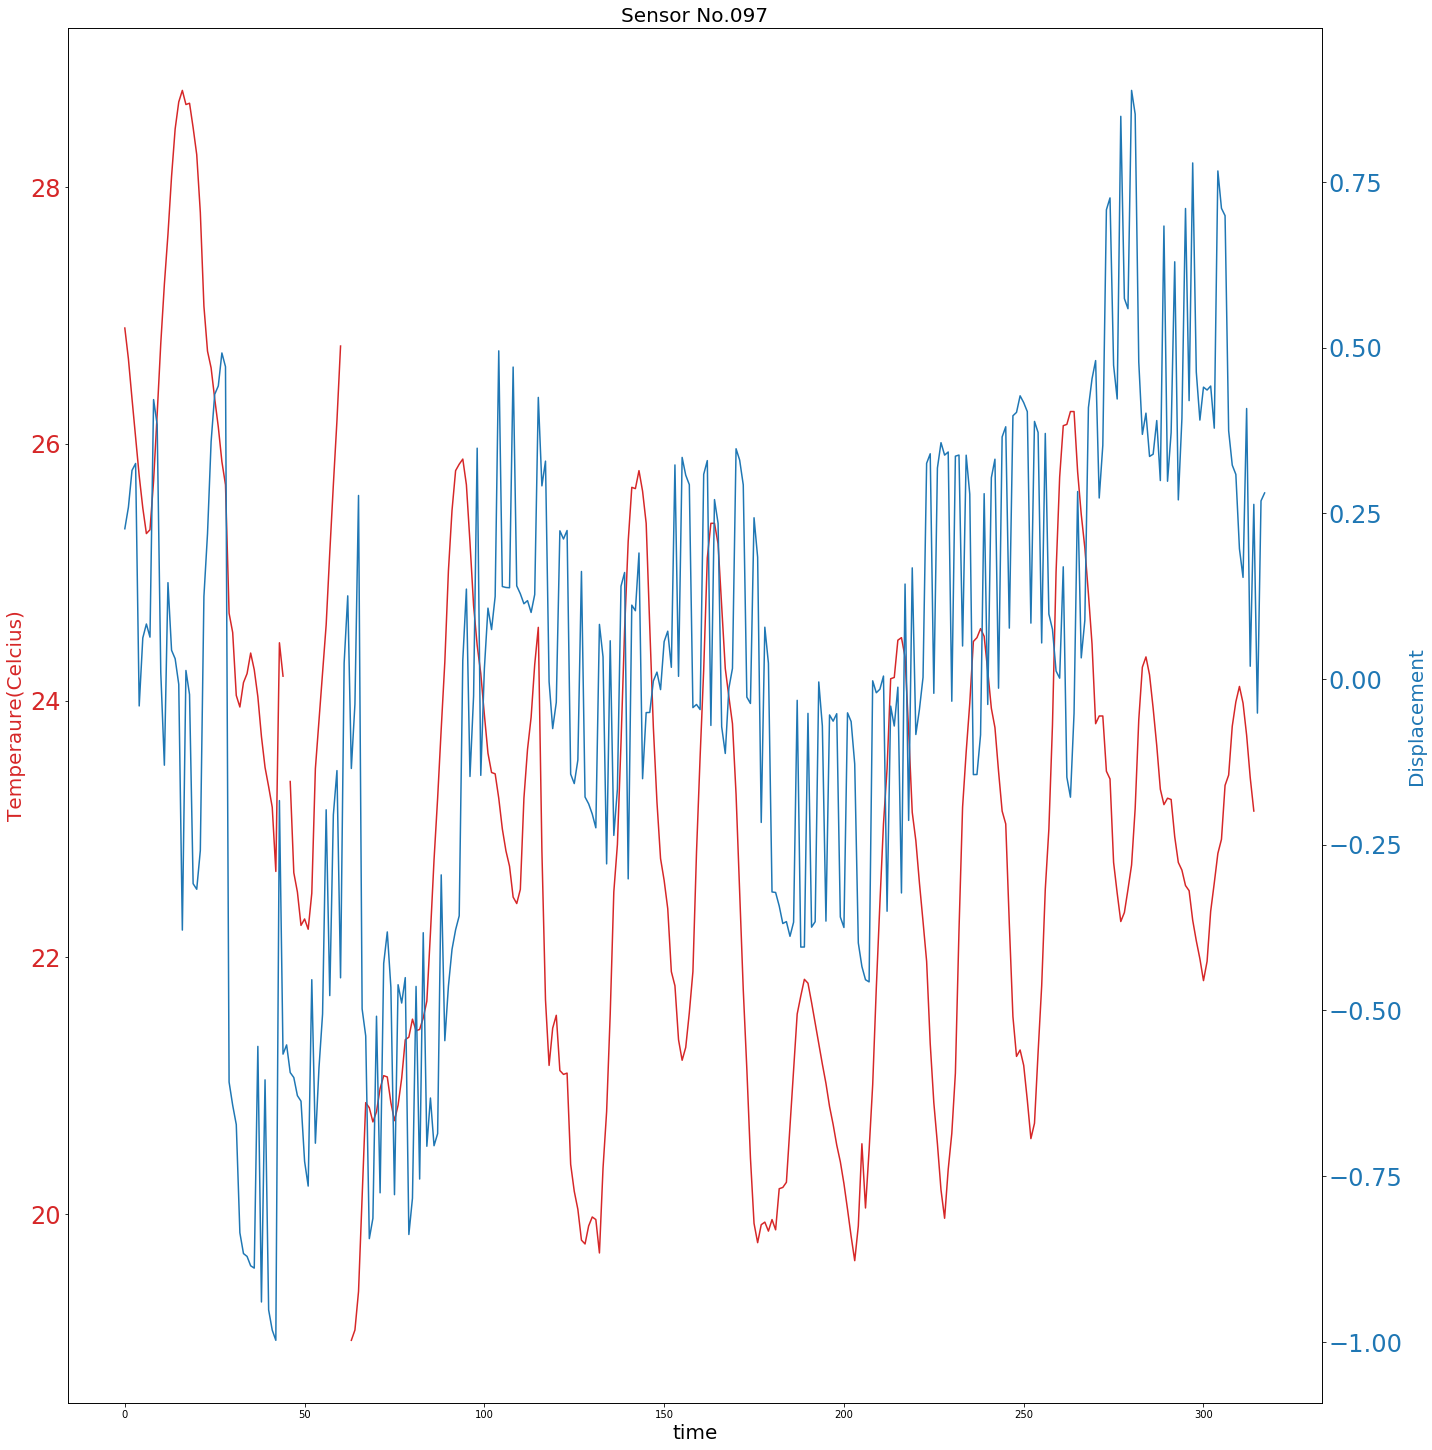

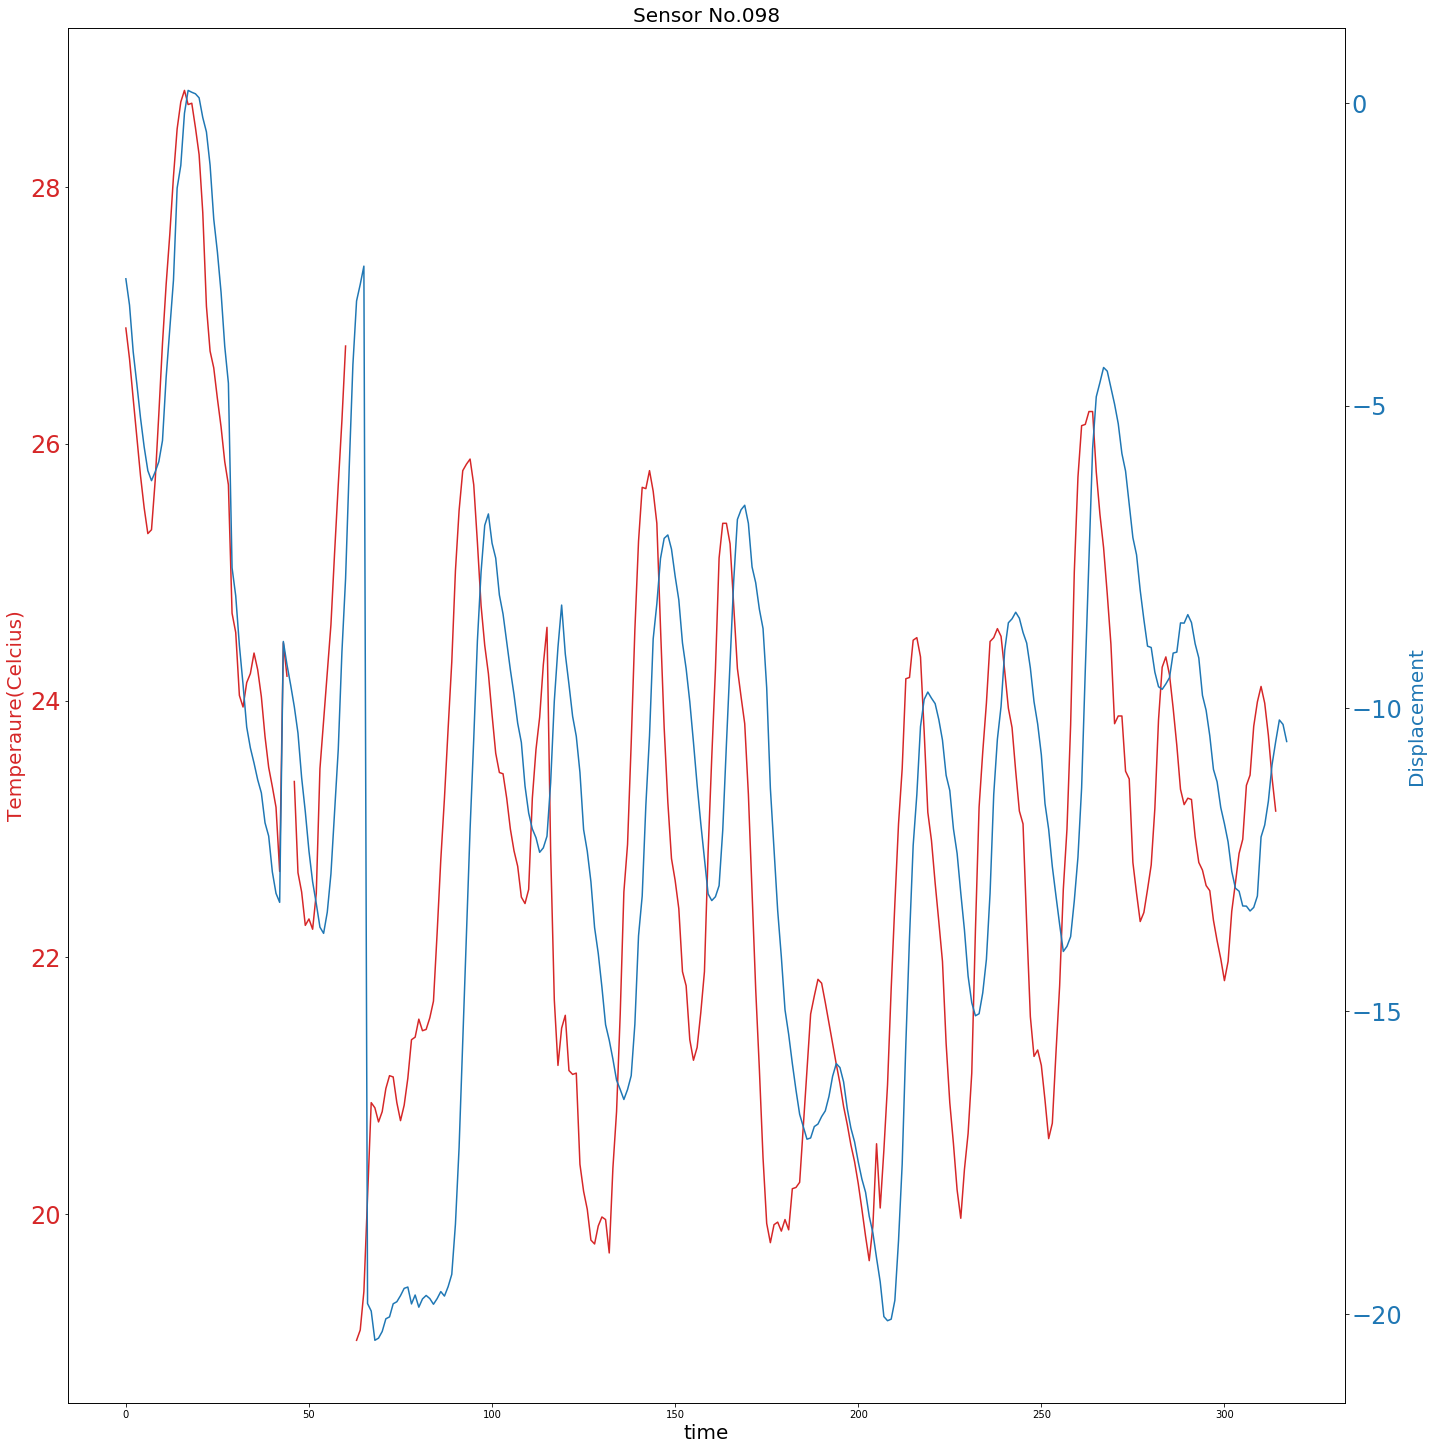

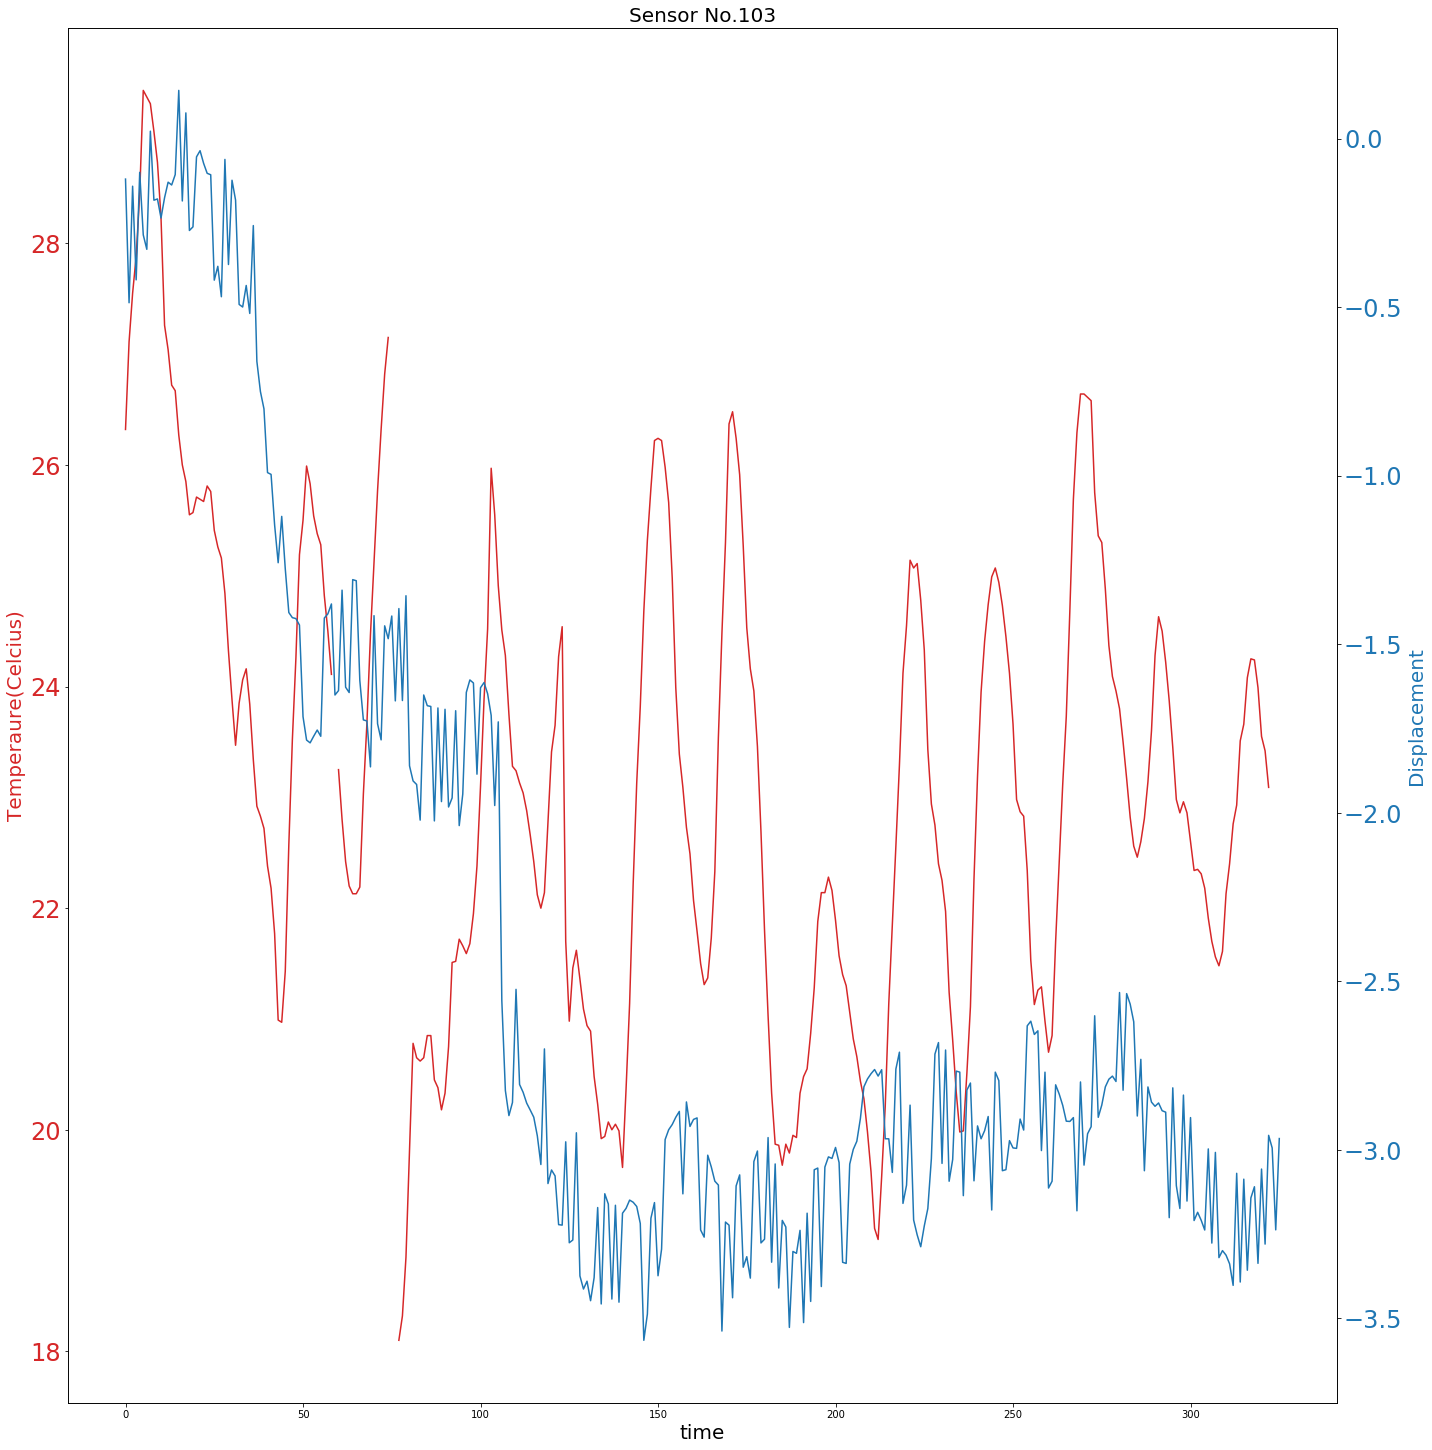

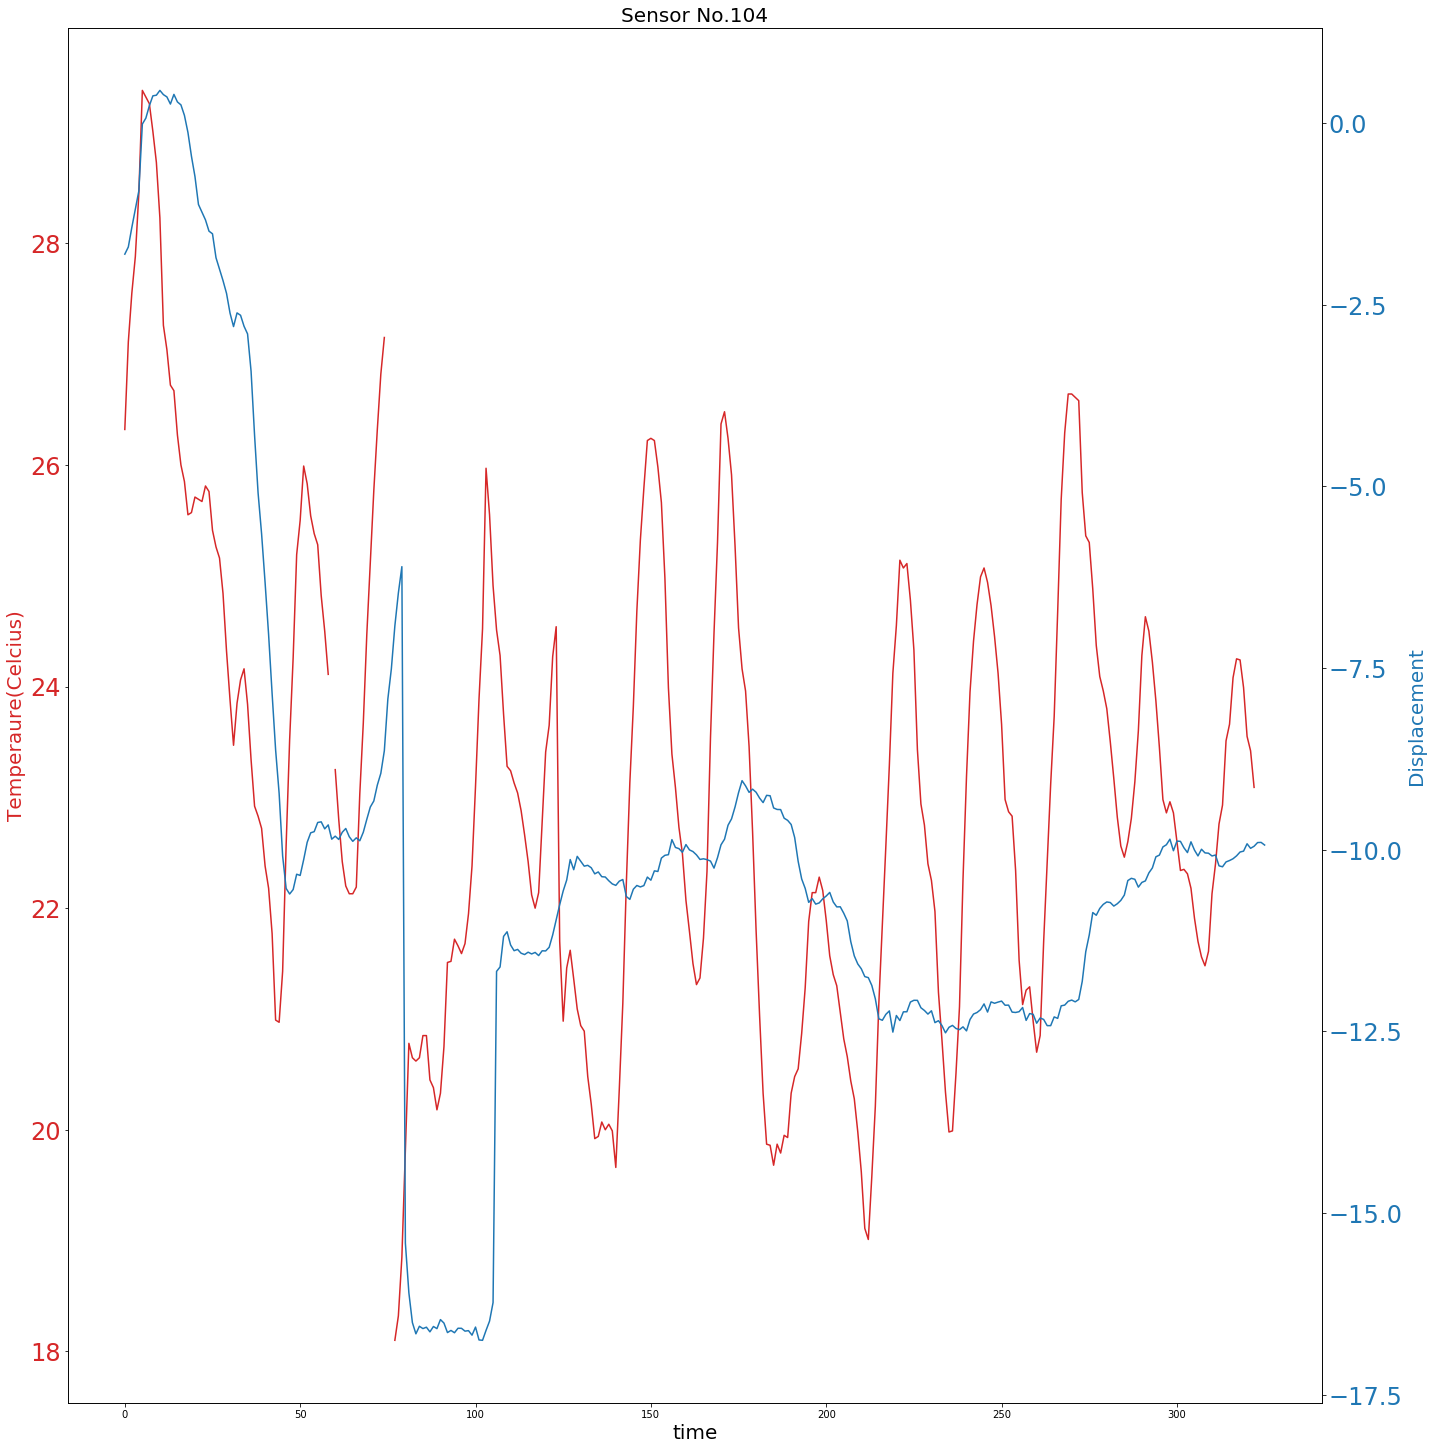

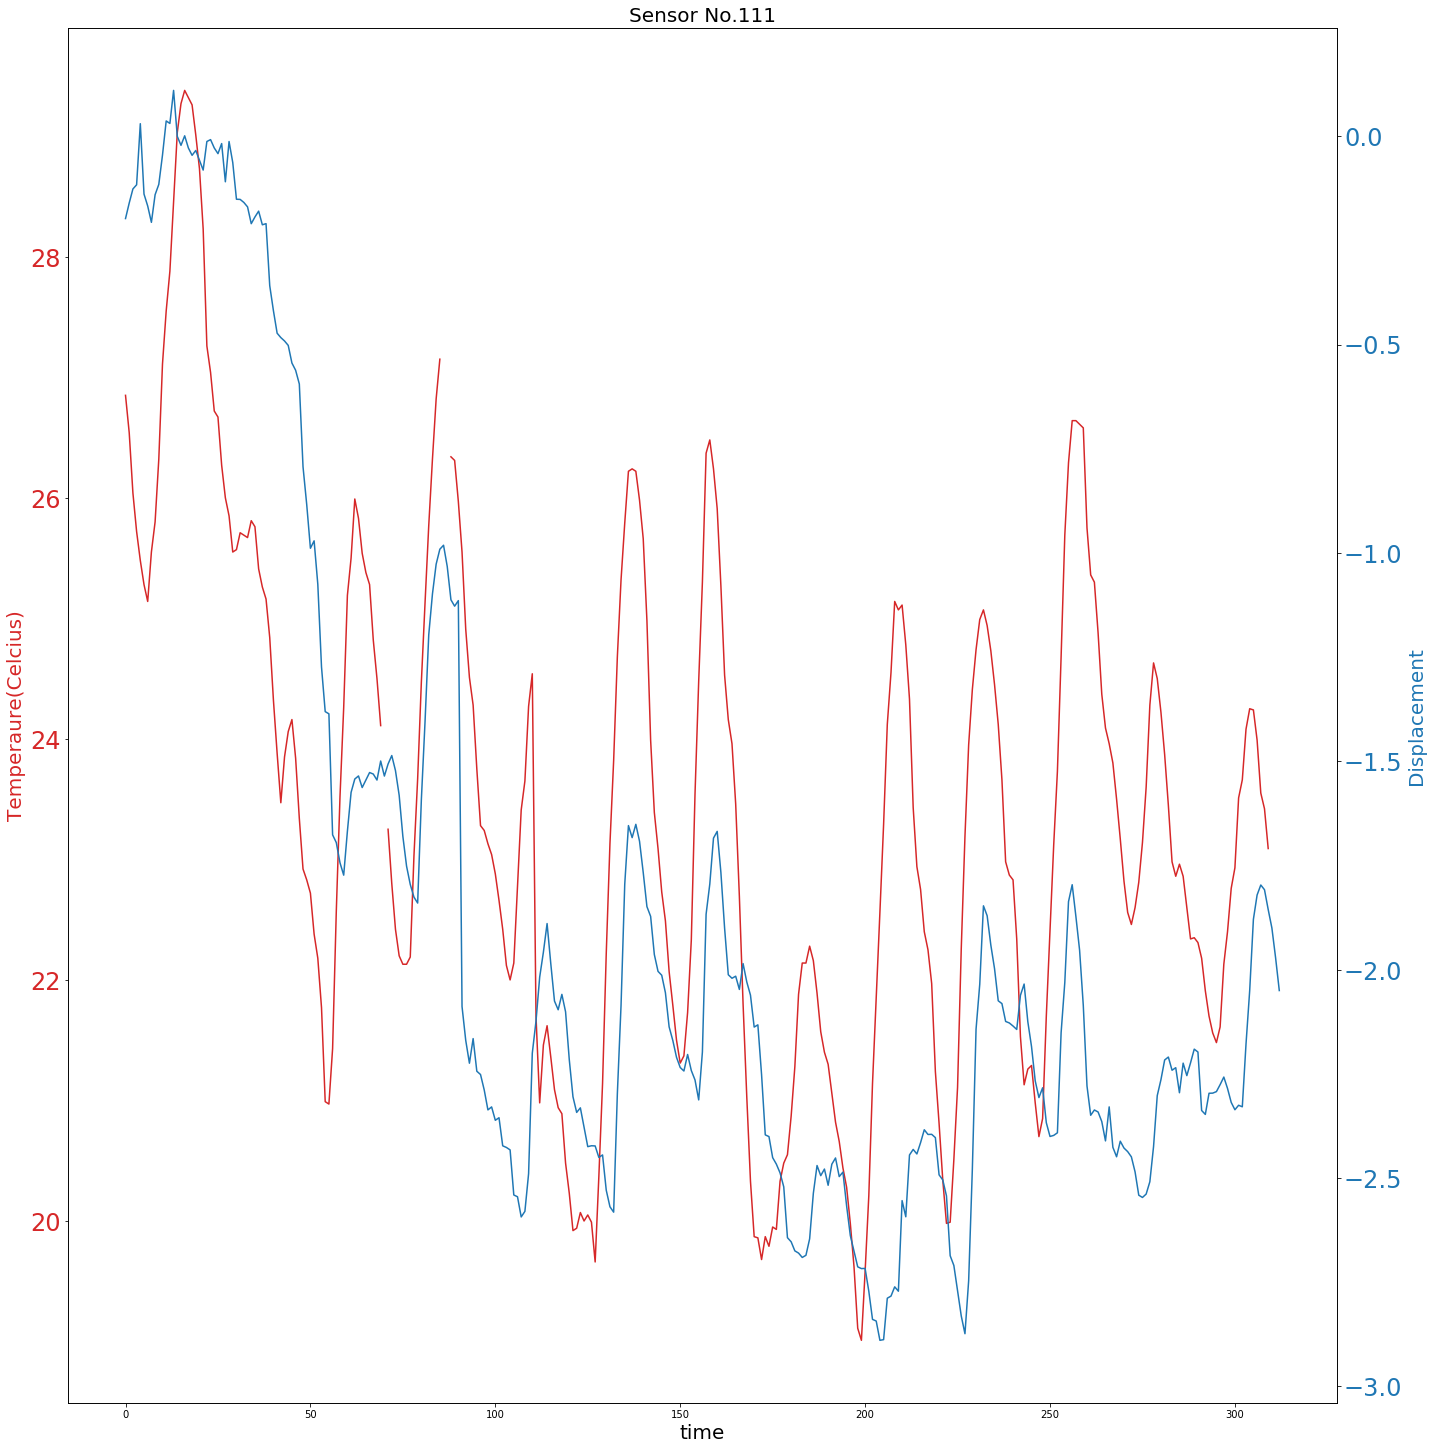

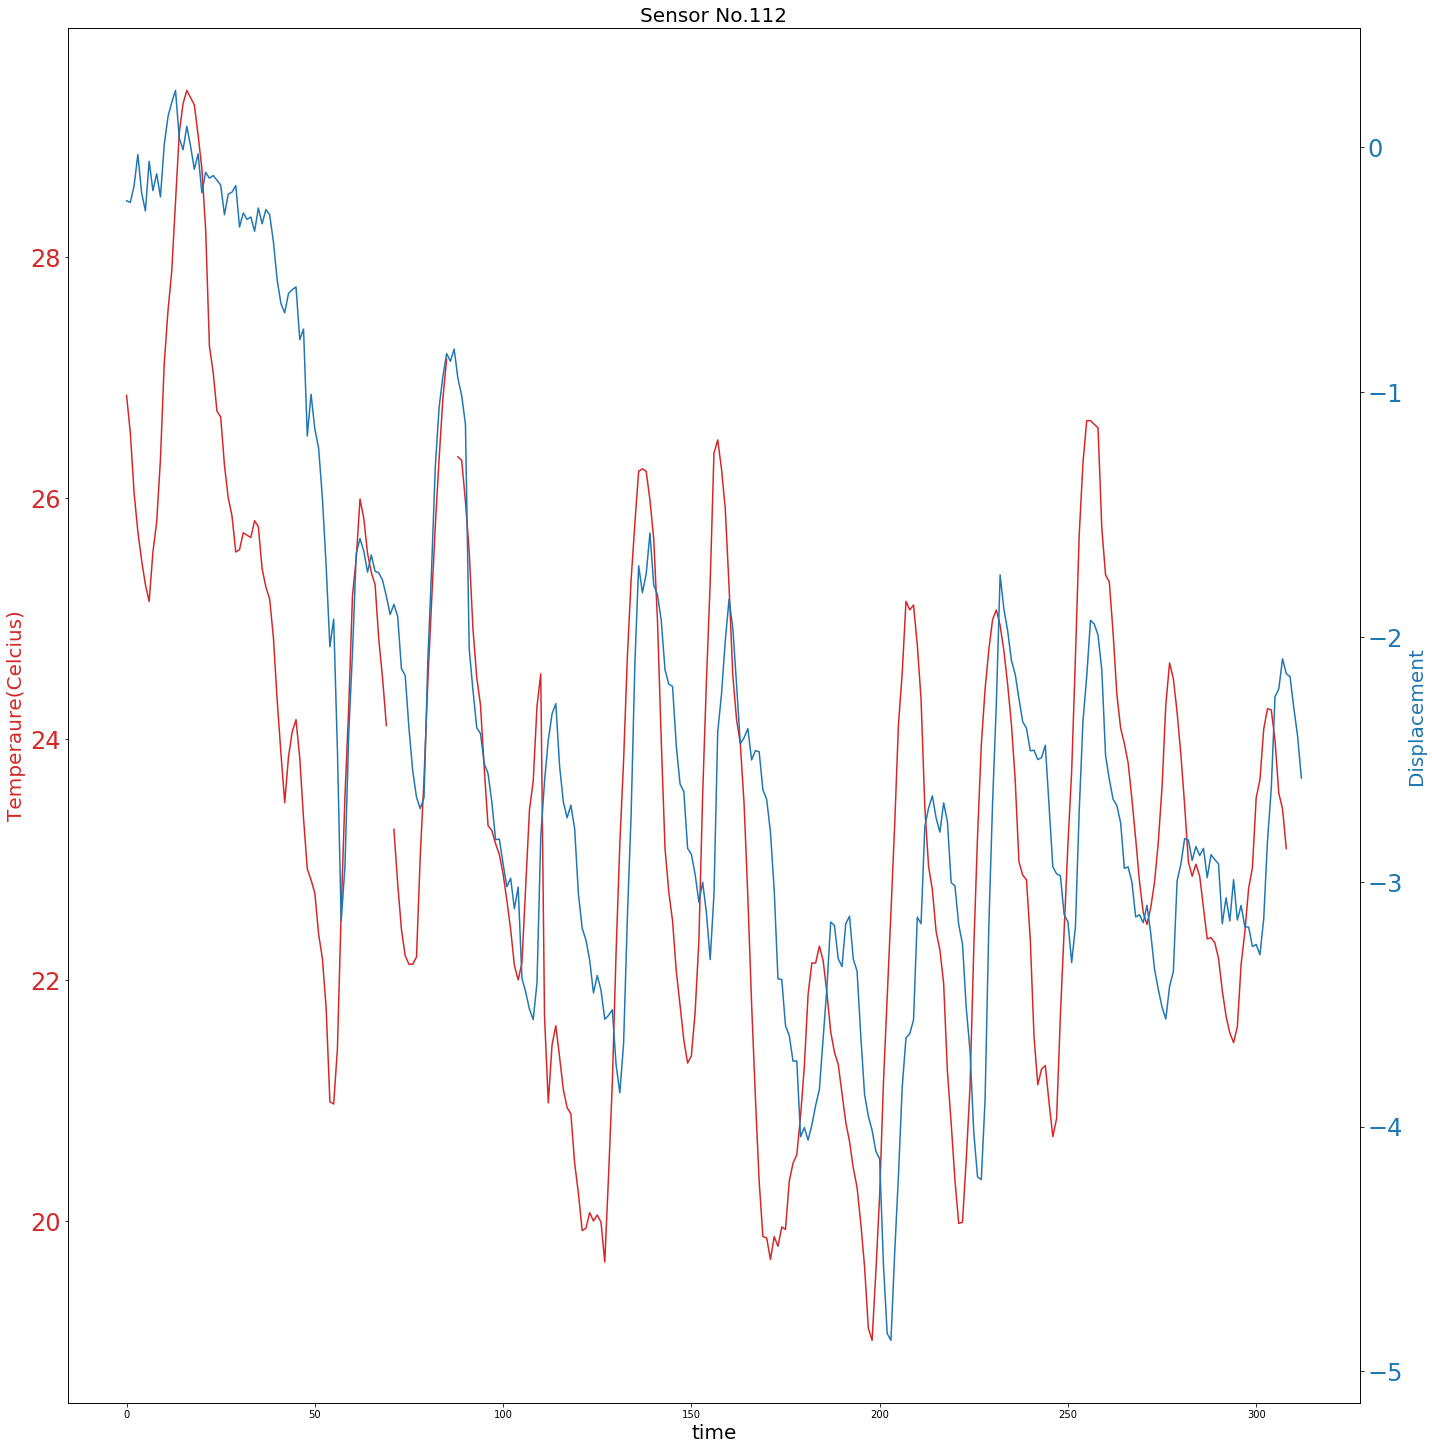

In [64]:
disp_pd = pd.read_csv(os.path.join('analysis_table.csv'))
temp_ps = pd.read_csv(os.path.join('imgTempr_list_20200831_20200917.csv'))
sensor_info = pd.read_csv('sensor_info.csv')

date_list = []

for img_name in disp_pd['image_name']:
    if '_093_' in img_name :
        date_list.append(img_name[8:-4])

sensor_list = []

for img_name in disp_pd['image_name']:
    sensor_list.append(img_name[4:7])
    
sensor_uniq_list = np.unique(sensor_list)


for idx in range(len(sensor_uniq_list)) :

    sensor = sensor_uniq_list[idx]
    disp_list = []
    tmp_list = []
    for row in disp_pd.iterrows() :
        if sensor in row[1][0] : 
            disp_list.append(row[1][4])
    #         print()
            temp_row_index = temp_ps.loc[temp_ps['파일명'] == row[1][0]]

            for value in temp_row_index['온도값(℃)']:
                tmp_list.append(value)

    fig, ax1 = plt.subplots(figsize=(20, 20))
    

    color = 'tab:red'
    ax1.set_xlabel('time', fontsize = 20.0)
    ax1.set_ylabel('Temperaure(Celcius)', color=color, fontsize = 20.0)
    ax1.plot(tmp_list, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize = 24)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Displacement', color=color, fontsize = 20.0)  # we already handled the x-label with ax1
    if sensor_info[(sensor_info['Sensor ID'] == int(sensor.strip("0")))]["Displacement Direction"].values == 'Forward' :
        disp_list = [-disp for disp in disp_list]
        ax2.plot(disp_list, color=color)
    else : 
        ax2.plot(disp_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 24)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Sensor No.' + str(sensor),  size=20)
#     plt.show()
    plt.savefig(os.path.join('Sensor No.' + str(sensor) + '.png'  ))
    plt.close




In [ ]:
for v, k in param_config.items():

    param_config[v]['src_img'] = 'Img_' + v + '_20200901_160100.jpg'
    
with open('params.json', 'w', encoding='utf-8') as f:
    json.dump(param_config, f)
#     try:
#         del param_config[v]['src_center'] 
#     except : 
#         print('src_center does not exist')

In [ ]:

clear_previous_detection_results = True

if clear_previous_detection_results : 
    analysis_table = pd.DataFrame(columns=['image_name','centers_of_detected_circles','sensitivity',
                                           'num_centers','x_displacement','y_displacement'])



for img_file in tqdm(img_list_for_cd) : 
    img_name = os.path.basename(img_file)
    num_image_in_the_cvs = len(np.where(analysis_table['image_name']== img_name)[0])
    num_circles = 0
    
    if num_image_in_the_cvs :  
        img_idx = int(np.where(analysis_table['image_name']== img_name)[0]) 
        num_circles = analysis_table['num_centers'][img_idx] 
    
    if num_image_in_the_cvs == 0 or num_circles != 4 :
        sensor_num = str(os.path.basename(img_name)[4:7])
        if sensor_num in param_config: 
            params = param_config[sensor_num]
            img = imread(img_file)
            sensitivity = params['sensitivity']
            centers, r_estimated, metric = imfindcircles(img, 
                                                 [params['min_rad'], params['max_rad']],
                                                sensitivity = sensitivity)
            circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
            circles = np.squeeze(circles)
            
        if num_image_in_the_cvs : 
            analysis_table['centers_of_detected_circles'] = circles
            
        else : 
            new_row = [img_name , circles, sensitivity, float('NaN'),  float('NaN'), len(circles)]
            s = pd.Series(new_row, index=analysis_table.columns )
            analysis_table = analysis_table.append(s, ignore_index=True)
            
# analysis_table.sort_values(by = 'image_name')
# analysis_table.to_csv('analysis_table.csv',index=False)

